In [4]:
import torch
import numpy as np
from globalbiopak.ptychography import Ptychography
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


80.0
-19


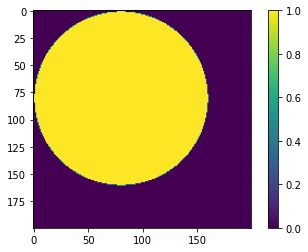

In [118]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
ptycho = Ptychography(size=200,n_img=16,device=device, probe_shape="disk",
            probe_radius=0.8)
print(ptycho.probe_radius*100)
probe_fig_data = torch.zeros(ptycho.size, ptycho.size).to(device)
for i_plot in range(1):
    shift_x = ptycho.shifts_x[i_plot]
    print(shift_x)
    shift_y = ptycho.shifts_y[i_plot]
    shifted_probe = torch.roll(
        ptycho.probe, shifts=(shift_x, shift_y), dims=(0,1))
    probe_fig_data += shifted_probe
plt.imshow(torch.abs(probe_fig_data.cpu()))
plt.colorbar();

In [37]:
38/80

0.475

Size of the input data: torch.Size([200, 200])


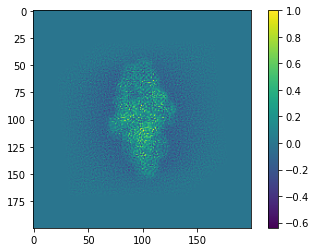

In [69]:
from globalbiopak.dataloader import loaddata
proj = loaddata('cryoEM')

downsampling_ratio = 1
proj = proj[::downsampling_ratio, ::downsampling_ratio]

print(f"Size of the input data: {proj.shape}")

phase_scale = 1
proj = proj / torch.amax(proj, dim=(0,1))
obj = torch.exp(1j * proj * phase_scale).to(device)
plt.imshow(torch.angle(obj).cpu())
plt.colorbar();

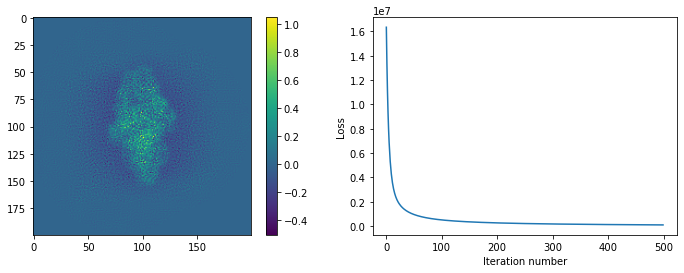

In [71]:
meas = ptycho.apply(obj)
x_est, loss_history = ptycho.PIE(meas, n_iter=500, lr=0.1, momentum=0.0)
plt.figure(figsize=(12,4))
# plt.subplot(1,3,1)
# plt.imshow(torch.abs(x_est.cpu().detach()))
# plt.colorbar()
plt.subplot(1,2,1)
plt.imshow(torch.angle(x_est.cpu().detach()))
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(loss_history[:])
plt.ylabel('Loss')
plt.xlabel('Iteration number')
plt.show()

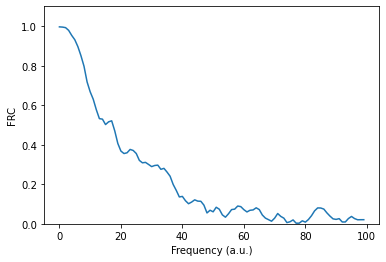

In [108]:
f_obj = torch.fft.fft2(obj).type(torch.complex128)
f_est = torch.fft.fft2(x_est).type(torch.complex128)

center = int(ptycho.size / 2)
ring_corr = torch.empty(center).to(device)
delta_radius = 5
x = np.linspace(0, ptycho.size, ptycho.size, dtype=np.uint)
xx,yy = np.meshgrid(x, x)
r2 = ((xx-center)**2 + (yy-center)**2)
for radius in range(center):
    mask = (r2 > radius**2) * (r2 < (radius+delta_radius)**2)
    mask = np.fft.fftshift(mask)

    f_obj_ring = f_obj[mask]
    f_est_ring = f_est[mask]
    ring_corr[radius] = torch.abs(f_obj_ring.T.conj() @ f_est_ring) / torch.norm(f_obj_ring) / torch.norm(f_est_ring)
plt.plot(ring_corr.detach().cpu())
plt.ylim(0, 1.1)
plt.ylabel("FRC")
plt.xlabel("Frequency (a.u.)")
plt.show()

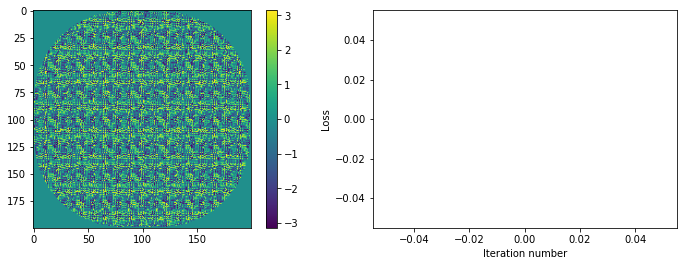

In [119]:
meas = ptycho.apply(obj)
x_est, loss_history = ptycho.conjugate_gradient(meas, n_iter=0, lr=1e-4)
x_est = ptycho.spectralinit(meas, n_iter=10, method="Lu")
plt.figure(figsize=(12,4))
# plt.subplot(1,3,1)
# plt.imshow(torch.abs(x_est.cpu().detach()))
# plt.colorbar()
plt.subplot(1,2,1)
plt.imshow(torch.angle(x_est.cpu().detach()))
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(loss_history[:])
plt.ylabel('Loss')
plt.xlabel('Iteration number')
plt.show()

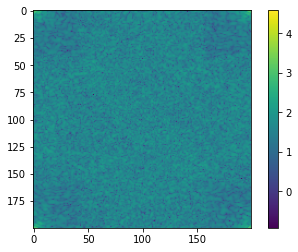

In [ ]:
plt.imshow(torch.log10(torch.abs(f_obj).cpu()))
plt.colorbar()

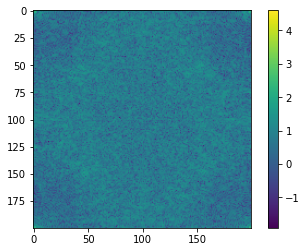

In [ ]:
plt.imshow(torch.log10(torch.abs(f_est).cpu()))
plt.colorbar()

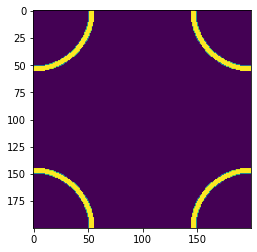

In [ ]:
radius = 51
delta_radius = 5
center = int(size / 2)
x = np.linspace(0, size, size, dtype=np.uint)
xx,yy = np.meshgrid(x, x)
r2 = ((xx-center)**2 + (yy-center)**2)
mask = (r2 > radius**2) * (r2 < (radius+delta_radius)**2)
mask = np.fft.fftshift(mask)
plt.imshow(mask)